# Numero: Digit Recognition

It is a convolutional neural network prepared for the Digit Recognizer competition on Kaggle with the aim of identifying digits from a dataset of handwritten images.

The original notebook: https://www.kaggle.com/myasiny/numero-digit-recognition

In [1]:
import os
import warnings
import pandas as pd

# Ignore warnings

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Show input data files

for dirname, _, filenames in os.walk("data/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/.DS_Store
data/test.csv
data/train.csv


# DATA

In [2]:
# Train set

df_train = pd.read_csv("data/train.csv", index_col=False)
df_train.shape

(42000, 785)

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Test set

df_test = pd.read_csv("data/test.csv", index_col=False)
df_test.shape

(28000, 784)

In [5]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Pre-processing

In [6]:
# Separate features & labels

df_X, df_y = df_train.drop(labels=["label"], axis=1), df_train["label"]

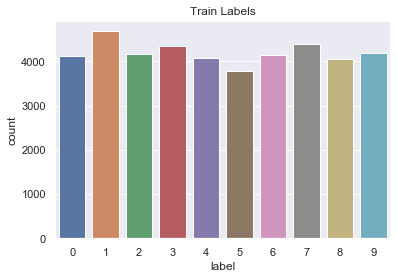

In [7]:
import seaborn as sns

# Visualize distribution of given data

def plot_count(df, title, clr="darkgrid"):
    sns.set(style=clr)
    ax = sns.countplot(df)
    ax.set_title(title)
    
plot_count(df_y, "Train Labels")

In [8]:
import numpy as np

# Reshape pixels into 3D matrices

def reshape_3d(df, h, w, channel):
    if not isinstance(df, np.ndarray):
        df = df.values
    return df.reshape(-1, h, w, channel)

df_X = reshape_3d(df_X, 28, 28, 1)

In [9]:
from keras.utils.np_utils import to_categorical

# Encode labels to one-hot vectors

df_y = to_categorical(df_y)
df_y.shape

Using TensorFlow backend.


(42000, 10)

### Preparation

In [10]:
from sklearn.model_selection import train_test_split

# Create train and validation sets

X_train, X_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
X_train.shape

(33600, 28, 28, 1)

In [11]:
# Calculate mean (𝜇) and standard deviation (𝜎) of train set

X_train_mean = X_train.mean().astype(np.float32)
X_train_std = X_train.std().astype(np.float32)

# Rescale pixels to have 𝜇 of 0 and 𝜎 of 1

def standardize(df, mean=X_train_mean, std=X_train_std):
    return (df - mean) / std

# MODEL

In [18]:
from keras.models import Sequential

# Use Keras Sequential to create stack of layers

model = Sequential()

In [19]:
from keras.layers import Lambda 

# Add Lambda layer to perform standardization

model.add(Lambda(standardize, input_shape=(28, 28, 1)))

In [20]:
from keras.layers import Conv2D, MaxPool2D

# Add Conv2D and MaxPooling2D layers to create convolution kernel and downsample

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

In [21]:
from keras.layers.core import Flatten

# Add Flatten layer to transform input into 1D array

model.add(Flatten())

In [22]:
from keras.layers.core import Dense

# Add Dense layers to connect neurons in previous layers

model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="softmax"))

### Optimization

In [23]:
from keras.optimizers import RMSprop

# Add loss, optimizer, metrics functions

model.compile(optimizer=RMSprop(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

### Augmentation

In [24]:
from keras.preprocessing.image import ImageDataGenerator

# Generate batches of image data to avoid overfitting

genr = ImageDataGenerator()
genr.fit(X_train)

batches_train = genr.flow(X_train, y_train, batch_size=64)
batches_val = genr.flow(X_val, y_val, batch_size=64)

### Training

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               409856    
__________

In [25]:
history = model.fit_generator(
    epochs=10, 
    verbose=1,
    generator=batches_train, 
    steps_per_epoch=batches_train.n / batches_train.batch_size, 
    validation_data=batches_val, 
    validation_steps=batches_val.n / batches_val.batch_size
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
525/525 [==============================] - 11s 21ms/step - loss: 0.1725 - acc: 0.9468 - val_loss: 0.0493 - val_acc: 0.9849
Epoch 2/10
525/525 [==============================] - 11s 22ms/step - loss: 0.0485 - acc: 0.9849 - val_loss: 0.0489 - val_acc: 0.9844
Epoch 3/10
525/525 [==============================] - 11s 22ms/step - loss: 0.0316 - acc: 0.9905 - val_loss: 0.0386 - val_acc: 0.9871
Epoch 4/10
525/525 [==============================] - 11s 22ms/step - loss: 0.0231 - acc: 0.9929 - val_loss: 0.0343 - val_acc: 0.9888
Epoch 5/10
525/525 [==============================] - 11s 22ms/step - loss: 0.0161 - acc: 0.9947 - val_loss: 0.0456 - val_acc: 0.9888
Epoch 6/10
525/525 [==============================] - 12s 22ms/step - loss: 0.0122 - acc: 0.9963 - val_loss: 0.0417 - val_acc: 0.9882
Epoch 7/10
525/525 [==============================] - 11s 22ms/step - loss: 0.0092 - acc: 0.9975 - va

### Evaluation

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline

i = range(1, len(history.history["loss"]) + 1, 1)

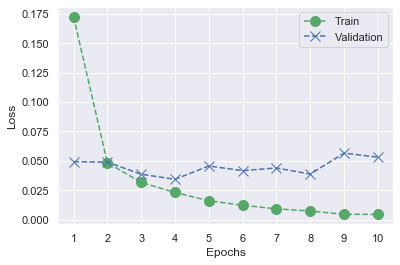

In [27]:
plt.plot(i, history.history["loss"], "go--", markersize=10, label="Train")
plt.plot(i, history.history["val_loss"], "bx--", markersize=10, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(i)
plt.legend()
plt.show()

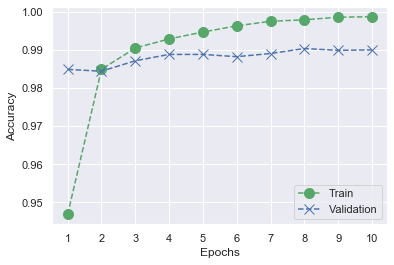

In [31]:
plt.plot(i, history.history["acc"], "go--", markersize=10, label="Train")
plt.plot(i, history.history["val_acc"], "bx--", markersize=10, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(i)
plt.legend()
plt.show()

# RESULT

In [33]:
# Preprocess test set

df_test = reshape_3d(df_test, 28, 28, 1)

In [34]:
# Predict labels

preds = model.predict_classes(df_test, verbose=1)

28000/28000 [==============================] - 3s 111us/step


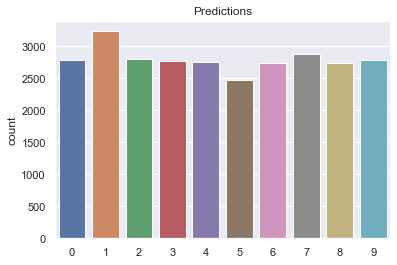

In [35]:
plot_count(preds, "Predictions")

In [36]:
import csv

# Export predictions to csv file

with open("out/result.csv", "w") as f:
    writer = csv.DictWriter(f, fieldnames=["ImageId", "Label"])
    writer.writeheader()
    for i in range(len(preds)):
        writer.writerow({"ImageId": i + 1, "Label": preds[i]})

### Sample

In [37]:
# Render pixels as image and show label along with prediction

def show_sample(i, X=X_train, y=y_train, model=model, h=28, w=28, channel=1, clr="gray"):
    pred = model.predict_classes(reshape_3d(X[i], h, w, channel))
    lbl = np.where(y[i] == 1)[0]
    plt.imshow(X[i][:, :, 0], cmap=plt.get_cmap(clr))
    if lbl == pred:
        status = "OK"
    else:
        status = "NOK"
    plt.title("{}\nLabel: {}, Prediction: {}".format(status, lbl[0], pred[0]))

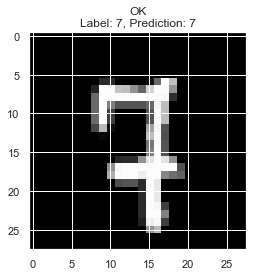

In [38]:
show_sample(11)

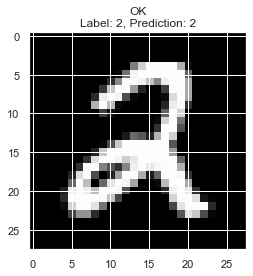

In [39]:
show_sample(100)

Kaggle score: 0.98